# Tutorial 1: Beginner level
This tutorial presents the fastest way to calculate inverse solutions using esinet. Please make sure to also visit Tutorial 2, as it clarifies many of the processes running in the dark and fosters understanding of the parameters.

In [1]:
#%matplotlib inline
#%load_ext autoreload
#%autoreload 2

import mne  
import numpy as np
from copy import deepcopy
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet.simulation import Simulation
from esinet.net import Net
import os

plot_params = dict(surface='inflated', cortex="low_contrast", hemi='both', verbose=0)
subjects_dir = os.path.join(mne.datasets.sample.data_path(), 'subjects')
mne.set_config('SUBJECTS_DIR', subjects_dir)

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 3.00TB/s]
Untarring contents of '/Users/zacariabalkhy/mne_data/MNE-sample-data-processed.tar.gz' to '/Users/zacariabalkhy/mne_data'


Download complete in 02m23s (1576.2 MB)


## Load the data
Just as in the [mne-python tutorial](https://mne.tools/stable/auto_tutorials/inverse/30_mne_dspm_loreta.html) we have to load some sample data first

In [ ]:
# join windows path with new string
#os.path.join(data_path, "/MEG/sample/sample_audvis-meg-oct-6-fwd.fif")
# windows path to stirng


In [2]:
data_path = mne.datasets.sample.data_path()
raw_fname = os.path.join(data_path, 'MEG', 'sample',
                    'sample_audvis_filt-0-40_raw.fif')

raw = mne.io.read_raw_fif(raw_fname, verbose=0)  # already has an average reference
events = mne.find_events(raw, stim_channel='STI 014', verbose=0)

event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
raw.info['bads'] = ['MEG 2443', 'EEG 053']
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('meg', 'eog'), baseline=baseline, reject=reject,
                    verbose=0)

fname_fwd = os.path.join(os.path.normpath(data_path).replace("\\", "/"), "MEG", "sample", "sample_audvis-meg-oct-6-fwd.fif")
fwd = mne.read_forward_solution(fname_fwd, verbose=0)


epochs_stripped = epochs.copy().load_data().pick_types(meg='mag')
fwd = fwd.pick_channels(epochs_stripped.ch_names)
fwd = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                                    use_cps=True, verbose=0)

Loading data for 72 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
17 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


## Visualize the sample data

Projections have already been applied. Setting proj attribute to True.


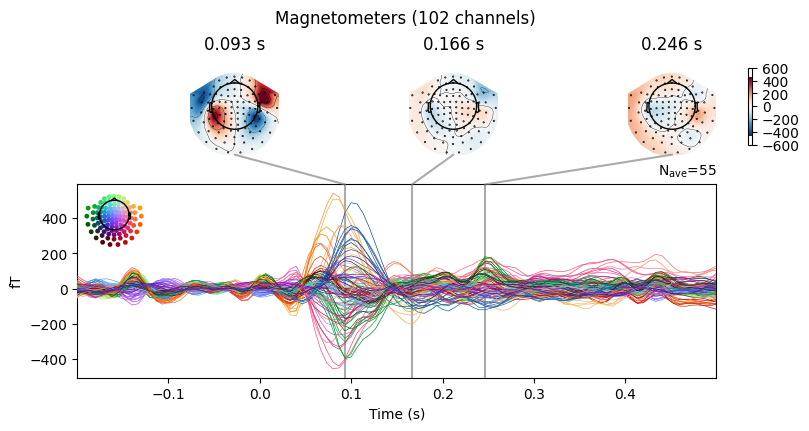

In [3]:
%matplotlib qt
epochs_stripped.average().plot_joint()

# Calculate the sources
You can use the simple wrapper function "calculate_source" to quickly perform 
all steps in one go! For best results, increase the number of training samples and epochs:  
  
n_samples = 10000  
n_epochs = 100

In [4]:
from esinet.util import calculate_source
source_estimate = calculate_source(epochs_stripped.average(), fwd, batch_size=8, n_samples=2000, n_epochs=30, duration_of_trial=0.01)

/Users/zacariabalkhy/UCDAVIS_COURSES/MAE298/final_project/esinet_MAE298/tutorials/../esinet/util/util.py:228: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.evoked.EvokedArray'>.tmin (-0.199795 s)
  data_base = evoked.copy().crop(*baseline_span)._data
/Users/zacariabalkhy/UCDAVIS_COURSES/MAE298/final_project/esinet_MAE298/tutorials/../esinet/util/util.py:230: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.evoked.EvokedArray'>.tmax (0.499488 s)
  data_signal = evoked.copy().crop(*data_span)._data
/Users/zacariabalkhy/UCDAVIS_COURSES/MAE298/final_project/esinet_MAE298/tutorials/../esinet/simulation.py:667: RuntimeWarning: 8.5% of original source space vertices have been omitted, tri-based adjacency will have holes.
Consider using distance-based adjacency or morphing data to all source space vertices.
  adj = mne.spatial_src_adjacency(self.fwd["src"], verbose=0).toarray().astype(int)


Simulate Source
Simulating data based on sparse patches.


100%|██████████| 2000/2000 [00:05<00:00, 342.55it/s]


Converting Source Data to mne.SourceEstimate object


100%|██████████| 2000/2000 [00:00<00:00, 57438.52it/s]



Project sources to EEG...

Create EEG trials with noise...


100%|██████████| 2000/2000 [00:01<00:00, 1344.78it/s]



Convert EEG matrices to a single instance of mne.Epochs...
preprocess data


/Users/zacariabalkhy/UCDAVIS_COURSES/MAE298/final_project/esinet_MAE298/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


fit model


/Users/zacariabalkhy/UCDAVIS_COURSES/MAE298/final_project/esinet_MAE298/tutorials/../esinet/net.py:1081: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  opt = minimize_scalar(self.correlation_criterion, args=(self.leadfield, y_est* base_scaler, x_true), \


Residual Variance(s): [48.14] [%]


# Plot the result

In [ ]:
source_estimate[0].plot(**plot_params)

Using control points [8.19302337e-11 1.00698605e-10 3.17006978e-10]


: 